# 03 Model Response Curves
Learn per-channel spend → conversions relationships using:
- Linear Regression (baseline, interpretable)
- Boosted Trees (HistGradientBoostingRegressor; XGBoost if available)

We’ll export smooth response curves per channel for optimization in Part 5.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Robust RMSE (works with any sklearn version)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Try XGBoost; fall back to HistGradientBoosting if not present
USE_XGB = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    print("XGBoost not available or failed to import; using HistGradientBoostingRegressor instead.\n", e)
    USE_XGB = False
    from sklearn.ensemble import HistGradientBoostingRegressor as HGBRegressor


In [5]:
df = pd.read_csv("../data/processed/campaign_daily_processed.csv", parse_dates=["date"])
assert {"date","channel","spend","conversions","is_weekend"}.issubset(df.columns)
df.head()

,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend,reach_pct,reach_people
0,2024-01-01,Display,17034.600163,8.0,2.129325e+06,39800.707300,16.688201,193917.599877,0,0,0.153431,153431.449644
1,2024-01-02,Display,12958.564783,8.0,1.619821e+06,32100.646122,11.707532,151922.240474,1,0,0.119635,119634.830582
2,2024-01-03,Display,15738.229635,8.0,1.967279e+06,41406.090975,19.405269,180838.502938,2,0,0.142869,142868.692820
3,2024-01-04,Display,18866.248209,8.0,2.358281e+06,50526.899773,15.448919,211968.914853,3,0,0.168067,168066.842534
4,2024-01-05,Display,12580.800920,8.0,1.572600e+06,31936.890565,24.994964,147898.558383,4,0,0.116415,116414.516144


In [6]:
df["log_spend"] = np.log1p(df["spend"].clip(lower=0))
df["sqrt_spend"] = np.sqrt(df["spend"].clip(lower=0))
df["month"] = df["date"].dt.month.astype(int)

# Feature set & target
FEATS = ["log_spend", "sqrt_spend", "month", "is_weekend"]
TARGET = "conversions"

# Quick sanity
df[FEATS + [TARGET, "channel"]].describe().T

,count,mean,std,min,25%,50%,75%,max
log_spend,1825.0,10.109454,0.650447,8.035396,9.568300,10.068574,10.673428,11.685992
sqrt_spend,1825.0,165.214901,53.719763,55.564023,119.595478,153.586777,207.826238,344.809463
month,1825.0,6.498630,3.444918,1.000000,4.000000,7.000000,9.000000,12.000000
is_weekend,1825.0,0.284932,0.451506,0.000000,0.000000,0.000000,1.000000,1.000000
conversions,1825.0,22.965372,6.144824,2.643110,18.806106,23.060088,26.834653,45.905964


In [7]:
channels = df["channel"].unique()
results = []
models = {}

for ch in channels:
    sub = df[df["channel"] == ch].copy()

    # Time-aware split: earliest 80% train, latest 20% test
    sub = sub.sort_values("date")
    n = len(sub)
    cut = int(n * 0.8)
    train, test = sub.iloc[:cut], sub.iloc[cut:]

    X_train, y_train = train[FEATS], train[TARGET]
    X_test,  y_test  = test[FEATS],  test[TARGET]

    # Linear baseline
    lr = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    rmse_lr_  = rmse(y_test, y_pred_lr)
    mae_lr_   = mean_absolute_error(y_test, y_pred_lr)

    # Boosted trees (prefer XGB if available)
    if USE_XGB:
        xgb = XGBRegressor(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            reg_lambda=1.0,
        )
        xgb.fit(X_train, y_train)
        y_pred_bt = xgb.predict(X_test)
        model_bt  = xgb
        model_name = "XGB"
    else:
        bt = HGBRegressor(max_depth=6, learning_rate=0.05, max_iter=400, random_state=42)
        bt.fit(X_train, y_train)
        y_pred_bt = bt.predict(X_test)
        model_bt  = bt
        model_name = "HGB"

    rmse_bt_ = rmse(y_test, y_pred_bt)
    mae_bt_  = mean_absolute_error(y_test, y_pred_bt)

    results.append({
        "channel": ch,
        "RMSE_LR": rmse_lr_,
        f"RMSE_{model_name}": rmse_bt_,
        "MAE_LR": mae_lr_,
        f"MAE_{model_name}": mae_bt_
    })

    models[ch] = {"lr": lr, "bt": model_bt, "bt_name": model_name}

pd.DataFrame(results).round(3)

,channel,RMSE_LR,RMSE_XGB,MAE_LR,MAE_XGB
0,Display,4.861,6.313,3.994,4.992
1,LinearTV,5.983,6.786,4.856,5.413
2,Social,6.011,7.055,4.765,5.645
3,Streaming,5.073,5.952,3.983,4.782
4,YouTube,5.016,5.653,4.100,4.417


In [8]:
import sys, inspect, sklearn
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)
print("inspect:", inspect.__file__)

Python: /Users/aravindanisetti/Desktop/2025 Training/Projects/.venv/bin/python
sklearn: 1.7.2
inspect: /usr/local/Cellar/python@3.11/3.11.14/Frameworks/Python.framework/Versions/3.11/lib/python3.11/inspect.py


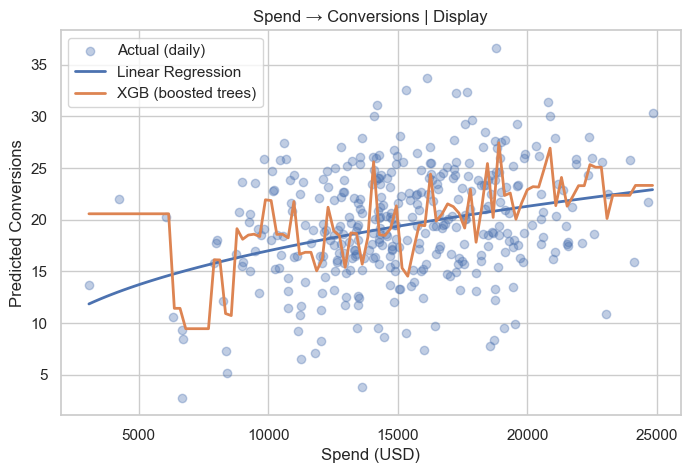

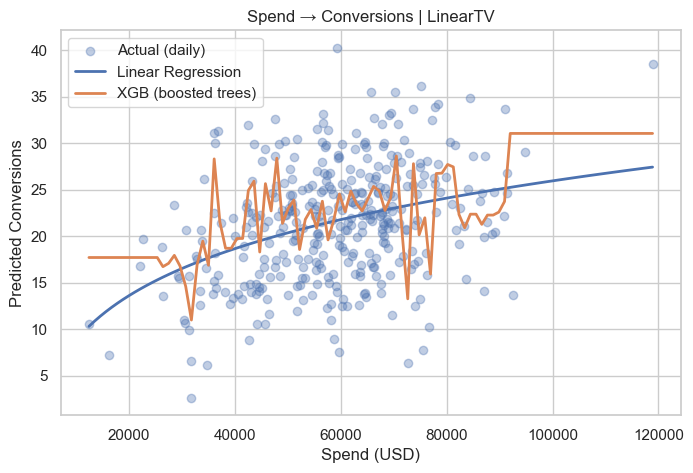

In [9]:
sns.set_theme(style="whitegrid")

def plot_response_curve(channel, month=6, is_weekend=0, num=100):
    sub = df[df["channel"]==channel]
    spend_grid = np.linspace(sub["spend"].min(), sub["spend"].max(), num)
    X_seq = pd.DataFrame({
        "log_spend": np.log1p(spend_grid),
        "sqrt_spend": np.sqrt(spend_grid),
        "month": month,
        "is_weekend": is_weekend
    })
    lr = models[channel]["lr"]
    bt = models[channel]["bt"]
    bt_name = models[channel]["bt_name"]

    pred_lr = lr.predict(X_seq)
    pred_bt = bt.predict(X_seq)

    plt.figure(figsize=(8,5))
    plt.scatter(sub["spend"], sub[TARGET], alpha=0.35, label="Actual (daily)")
    plt.plot(spend_grid, pred_lr, label="Linear Regression", linewidth=2)
    plt.plot(spend_grid, pred_bt, label=f"{bt_name} (boosted trees)", linewidth=2)
    plt.title(f"Spend → Conversions | {channel}")
    plt.xlabel("Spend (USD)")
    plt.ylabel("Predicted Conversions")
    plt.legend()
    plt.show()

# Example plot for two channels
for ch in channels[:2]:
    plot_response_curve(ch)

In [10]:
out_dir = Path("../data/processed/response_curves")
out_dir.mkdir(parents=True, exist_ok=True)

for ch in channels:
    sub = df[df["channel"]==ch]
    spend_grid = np.linspace(sub["spend"].min(), sub["spend"].max(), 120)

    X_seq = pd.DataFrame({
        "log_spend": np.log1p(spend_grid),
        "sqrt_spend": np.sqrt(spend_grid),
        "month": 6,
        "is_weekend": 0
    })

    lr = models[ch]["lr"]
    bt = models[ch]["bt"]
    bt_name = models[ch]["bt_name"]

    out = pd.DataFrame({
        "channel": ch,
        "spend": spend_grid,
        "pred_conversions_lr": lr.predict(X_seq),
        f"pred_conversions_{bt_name.lower()}": bt.predict(X_seq)
    })
    out.to_csv(out_dir / f"{ch.lower()}_response_curve.csv", index=False)

out_dir, list(out_dir.glob("*.csv"))[:3]

(PosixPath('../data/processed/response_curves'),
 [PosixPath('../data/processed/response_curves/social_response_curve.csv'),
  PosixPath('../data/processed/response_curves/youtube_response_curve.csv'),
  PosixPath('../data/processed/response_curves/lineartv_response_curve.csv')])